[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

This follows what we did previously.

In [1]:
from langchain_gigachat.chat_models import GigaChat
import yaml

def ask_question(question:str) -> int:
    """Переспросить неоднозначные моменты.
        Если видишь несостыковку данных таблицы и вопроса, спроси у пользователя.
        Спрашивай пока не получишь ответы на все вопросы.
    """
    return input(question)

tools = [ask_question]

with open("gpt_db/data/confs/config.yaml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
GIGACHAT_CREDENTIALS = config["GIGACHAT_CREDENTIALS"]

llm = GigaChat(
            credentials=GIGACHAT_CREDENTIALS,
            model="GigaChat-2-Max",
            verify_ssl_certs=False,
            temperature=0.01  # можно настраивать
        )
llm_with_tools = llm.bind_tools(tools)

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
import datetime

def _load_instruction():
   with open('gpt_db/data/confs/instruction_sql.txt', 'r', encoding='utf-8') as file:
      instruct = file.read().strip()
   with open('gpt_db/data/confs/otgruzki_structure.txt', 'r', encoding='utf-8') as file:
      db_shema = file.read().strip()
   with open('gpt_db/data/confs/divisions.txt', 'r', encoding='utf-8') as file:
      divisions = file.read().strip()
   return instruct.replace("[otgruzki_structure]", db_shema).\
      replace("[divizions]", divisions).replace("[date]", str(datetime.datetime.now())[:10])

# System message
sys_msg = SystemMessage(content=_load_instruction())

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
def assistant_comments(state: MessagesState):
   return {"messages": [llm_with_tools.invoke(SystemMessage(content="""
   Напиши три знака "===" и комментарий:  
   - Подстановка результатов через <поле1>, <поле2> - именно через номер поля
   - Пример: "Лучший менеджер <поле1> оформил <поле2> отгрузок"
   - Пиши Код Дивизиона по которой фильтровано
   - Пропиши точные даты как отфильтровано
   - Прописывай какие формулы используются

   Пример ответа:  
   SELECT VBRK_FKDAT as Shipment_Date, COUNT(VBRK_VBELN) as Shipment_Count
   FROM SAPABAP1.ZZSDM_117_CUS
   GROUP BY Shipment_Date
   ORDER BY Shipment_Count DESC
   LIMIT 1
   ===
   Больше всего отгрузок произошло <Shipment_Date>, когда было выполнено <Shipment_Count> отгрузок.""")+state["messages"])]}

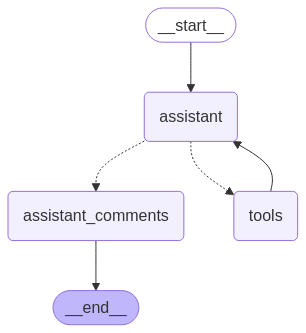

In [24]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("assistant_comments", assistant_comments)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # Проверяем, нужен ли переход в "tools" или "assistant_comments"
    lambda state: "tools" if tools_condition(state) else "assistant_comments",
    # Соответствие меток узлам
    {"tools": "tools", "assistant_comments": "assistant_comments"}
)
builder.add_edge("tools", "assistant")
# builder.add_edge("assistant", "assistant_comments")
builder.add_edge("assistant_comments", END)
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [26]:
user_querys = [
        
        "Покажи отгрузки за сегодня",
        "Сколько в прошлом месяце отгрузили на Урале",
        "Сколько клиентов отгрузилось на дальнем востоке в прошлом году",
            "Кто из них грузился чаще?",
        "Какой менеджер совершил больше всего продаж в прошлом месяце?",
            "посчитай по тоннажу",
        "В какой день было больше всего отгрузок?",
        "Скажи материал с самой большой наценкой",
        "Скажи АГ1 с самой большой наценкой",
        "Назови топ 10 клиентов за прошлый год",
        "У каких материалов самая большая себестоимость за прошлую неделю?",
        "Назови топ 3 дивизиона за прошлый месяц",
            "Назови выручку по этим дивизионам ",
        "Сколько вчера отгрузили в Японии?"
    ]

In [27]:
user_querys[0]

'Покажи отгрузки за сегодня'

In [35]:
# Specify a thread
config = {"configurable": {"thread_id": "5"}}

# Specify an input
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content=user_querys[0])]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

ReadTimeout: The read operation timed out

### Old graph

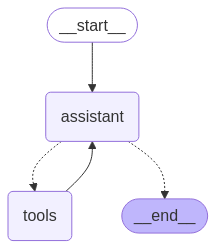

In [3]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [8]:
# Specify a thread
config = {"configurable": {"thread_id": "5"}}

# Specify an input
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content="Покажи отгрузки за сегодня")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Покажи отгрузки за сегодня
================================== Ai Message ==================================

SELECT VBRK_VBELN AS Invoice_Code,
       VBRP_POSNR AS Position_Number,
       VBRK_FKDAT AS Shipment_Date,
       VBRK_ZZPERNR_ZM AS Manager_Code,
       VBRP_MATNR AS Material_Code,
       VBRP_FKIMG AS Quantity_Sold,
       ZAREVENF_RUB AS Revenue_RUB
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT = '20250326'


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
# messages = [HumanMessage(content="Сколько клиентов отгрузилось на дальнем востоке в прошлом году")]
for query in user_querys[2:]:
    messages = [HumanMessage(content=query)]

    # Run
    messages = react_graph_memory.invoke({"messages": messages},config)
    for m in messages['messages']:
        m.pretty_print()
    print("#"*100)

================================ Human Message =================================

Покажи отгрузки за сегодня
================================== Ai Message ==================================

```sql
SELECT VBRK_VBELN AS КодФактуры,
       VBRP_POSNR AS ПозицияФактуры,
       VBRK_FKDAT AS ДатаФактуры,
       VBRK_ZZPERNR_ZM AS МенеджерСделки,
       VBRP_MATNR AS Материал,
       VBRP_FKIMG AS Количество,
       ZAREVENF_RUB AS ВыручкаРубли
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT = '20250326'
```
===
Сегодня были следующие отгрузки:
<КодФактуры>, <ПозицияФактуры>, <ДатаФактуры>, <МенеджерСделки>, <Материал>, <Количество>, <ВыручкаРубли>.
================================ Human Message =================================

Сколько в прошлом месяце отгрузили на Урале
================================== Ai Message ==================================

```sql
SELECT SUM(VBRP_FKIMG) AS ОбщееКоличествоОтгруженного
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT >= '20250201' -- Начало прошлого мес